## Rakeshwer's Master Thesis 2022: 

### "Time Series Prediction with ANNs on non-linear and non-stationary Time Series"

**Note:** Former working title was slightly different: "Predicting Regime Shifts for non-linear and non-stationary Time Series with Artificial Neural Networks".

**Research Questions:**

- **Q0:** Set the benchmark: How do **naive heuristics** perform? Try naive buy&hold strategy, which means being always long. Then the accuracy is supposed to be the relative amount of UP movements. Then - in addition to naive buy&hold - take majority vote of last *k* days movement as predictor for next day. What accuracy do we achieve with that? And do we already outperform the naive buy&hold approach? Get baselines for Train / Validation / Test data seperately for both heuristics and all four targets.
- **Q1:** Can we predict trends in stock price movements from their own history alone? (open, high, low, close, range, traded shares, observed volatility, moving averages, RSI, MACD, Bollinger limits) —> We expect to fail and get only poor accuracy (50%). These are all **technical features**.
- **Q2:** Do **external features** help improving accuracy? (mostly macroeconomic indices: GDP, inflation expectation, interest rates,...)
- **Q3:** If we still get poor results, why and where do our models fail? Do we find similarities in terms of patterns or regimes, in which our model performs better or worse? (e.g. high volatility regime,...) Start with analysing samples with highest loss (deviation of prediction from true target), then apply (subspace-)clustering in input feature space.
- **Q4:** And eventually we want to make use of our models and try to set up some trading model, that beats the market (= naive buy-and-hold). Plot cumulative outperformance, cumulative gain from naive buy-and-hold and closing price history (abs values), to recognize, in which market situations our model performs best.

**Outline:**

Here we start to tackle the first question. 

Before we start, we need to import data from *csv* file - preprocessed in EXCEL. **Note:** Start with S&P500 data history at Jan 7th, 1985, since from there on we have all values available. The limiting factor is Baltic Dry Index. Without that we could start in April 1982, since from there on we find open/high/low/close/vol on [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC). Then:

- **Split input values into sequences** of specified input length
- Split inputs and targets into **train / validation / test sets**, according to year:
 - Train data: 1985 .. 2009
 - Val data:   2010 .. 2019
 - Test data:  2020 .. end
- **Apply min max scaling** to train / val / test inputs: Substract min and divide by (max - min)
- **Check distribution of inputs** values after transformation for each input feature
- Play with **customized loss functions** and define "gain" and "outperformance"
- **Set up first model**: Some **CNN/fc** model on scaled close (rel chg) values as **single input feature** and 1d close (rel chg) as **target**
 - Trained on classic mse as loss function
 - Get binary accuracy (correctly predicted UP/DOWN movements)
 - Fidelity check: One-step predictions vs. ground truth
 - Cumulative model gain vs. cumulative gain from naive buy-and-hold strategy
 - Visualize correct / false predictions
- **Set up first hybrid model**: Some **CNN/LSTM** hybrid model on scaled close (rel chg) values as **single input feature** and 1d close (rel chg) as **target**
 - Trained on different custom loss functions

### Tech Preamble

In [1]:
import sys
import datetime
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import data

In [2]:
# Define path to data folder:
path_to_data = "../data"

# Import data from csv file:
data = np.genfromtxt(join(path_to_data,'SP500_TechnicalFeatures.csv'), delimiter=';', skip_header=1)

# Check dimensions:
print("data shape (samples, features): ", data.shape)
print("\nfirst row: \n", data[0])

print("\nfeatures [column number]:")
print("=========================")
print("[0] - year")
print("[1] - open (abs)")
print("[2] - high (abs)")
print("[3] - low (abs)")
print("[4] - close (abs)")
print("[5] - close (rel chg)")
print("[6] - vol (abs)") # number of traded shares
print("[7] - vol (rel chg)")
print("[8] - range (abs)") # high - low
print("[9] - range (rel)") # range (abs) / close (abs)
print("[10] - target 1d (rel chg)")
print("[11] - target 5d (rel chg)")
print("[12] - target 10d (rel chg)")
print("[13] - target 20d (rel chg)")

data shape (samples, features):  (10093, 14)

first row: 
 [ 1.9820000e+03  1.1548000e+02  1.1587000e+02  1.1530000e+02
  1.1572000e+02  2.4255020e-03  5.7820000e+07  5.8780443e-02
  5.7000000e-01  4.9256830e-03  1.2703076e-02  1.3307985e-02
  1.6851020e-02 -7.1724850e-03]

features [column number]:
[0] - year
[1] - open (abs)
[2] - high (abs)
[3] - low (abs)
[4] - close (abs)
[5] - close (rel chg)
[6] - vol (abs)
[7] - vol (rel chg)
[8] - range (abs)
[9] - range (rel)
[10] - target 1d (rel chg)
[11] - target 5d (rel chg)
[12] - target 10d (rel chg)
[13] - target 20d (rel chg)


In [3]:
# Extract year for seperating data into train / validation / test sets
year = data[:,0]

## Extract some input features: Start with... 
# [5] - close (rel chg)
# [7] - vol (rel chg)
# [9] - range (rel)

inputs = data[:,(5, 7, 9)]

## Extract target values for 1d / 5d / 10d / 20d as rel chg:
# [10] - target 1d (rel chg)
# [11] - target 5d (rel chg)
# [12] - target 10d (rel chg)
# [13] - target 20d (rel chg)

targets = data[:,10:]

# Check dimensions:
print("year shape (samples): ", year.shape)
print("inputs shape (samples, input features): ", inputs.shape)
print("targets shape (samples, output features): ", targets.shape)

year shape (samples):  (10093,)
inputs shape (samples, input features):  (10093, 3)
targets shape (samples, output features):  (10093, 4)


In [4]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [5]:
# Split input values into sequences of specified input length:
input_length = 20
inputs_split = split_sequence(inputs, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
targets_cut = targets[input_length-1:]

# Check dimensions:
print("inputs shape AFTER splitting (samples, timesteps, input features): ", inputs_split.shape)
print("targets shape AFTER removing (input_length - 1) entries: ", targets_cut.shape)
print("data shape AFTER removing (input_length - 1) entries: ", data_cut.shape)
print("year shape AFTER removing (input_length - 1) entries: ", year_cut.shape)

inputs shape AFTER splitting (samples, timesteps, input features):  (10074, 20, 3)
targets shape AFTER removing (input_length - 1) entries:  (10074, 4)
data shape AFTER removing (input_length - 1) entries:  (10074, 14)
year shape AFTER removing (input_length - 1) entries:  (10074,)


In [6]:
# Check year range for raw data:
print("year ranges from", np.min(year_cut).astype(int), "to", np.max(year_cut).astype(int))

year ranges from 1982 to 2022


In [7]:
## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1982 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = targets_cut[year_cut <= 2009]
val_target = targets_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = targets_cut[year_cut >= 2020]

# Check dimensions:
print("INPUTS:")
print("=======")
print("train_input shape (samples, timesteps, input features): ", train_input.shape)
print("val_input shape (samples, timesteps, input features): ", val_input.shape)
print("test_input shape (samples, timesteps, input features): ", test_input.shape)

print("\nTARGETS:")
print("=======")
print("train_target shape (samples, timesteps, input features): ", train_target.shape)
print("val_target shape (samples, timesteps, input features): ", val_target.shape)
print("test_target shape (samples, timesteps, input features): ", test_target.shape)

INPUTS:
train_input shape (samples, timesteps, input features):  (6971, 20, 3)
val_input shape (samples, timesteps, input features):  (2516, 20, 3)
test_input shape (samples, timesteps, input features):  (587, 20, 3)

TARGETS:
train_target shape (samples, timesteps, input features):  (6971, 4)
val_target shape (samples, timesteps, input features):  (2516, 4)
test_target shape (samples, timesteps, input features):  (587, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

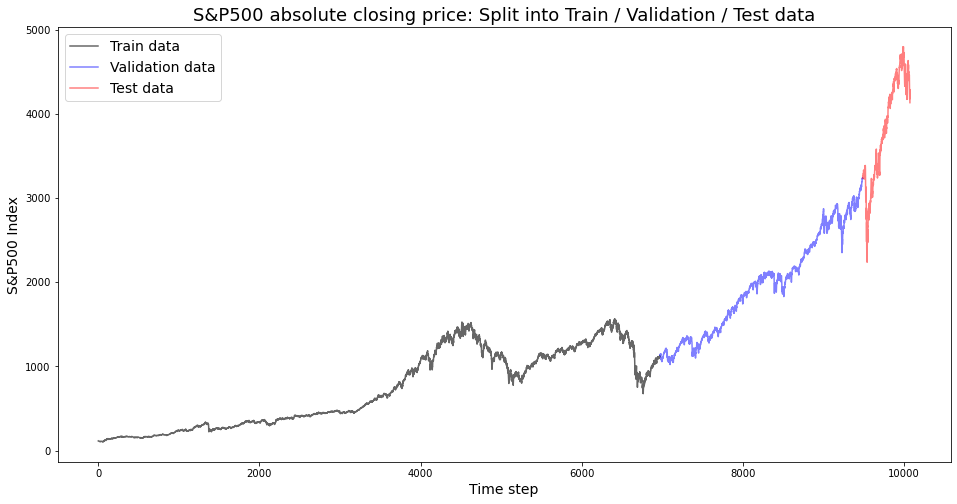

In [8]:
## Plot absolute closing price with split into train / val / test data:

# Get lengths:
n_train = len(train_input)
n_val = len(val_input)
n_test = len(test_input)

# Define ranges:
train_range = np.arange(0, n_train, 1)
val_range = np.arange(n_train, n_train + n_val, 1)
test_range = np.arange(n_train + n_val, n_train + n_val + n_test, 1)

# Plot:
plt.figure(figsize=(16,8))
plt.plot(train_range, data_cut[train_range,4],'k',label="Train data", alpha=0.6)
plt.plot(val_range, data_cut[val_range,4],'b',label="Validation data", alpha=0.5)
plt.plot(test_range, data_cut[test_range,4],'r',label="Test data", alpha=0.5)

plt.title('S&P500 absolute closing price: Split into Train / Validation / Test data', fontsize=18)
plt.xlabel('Time step', fontsize=14)
plt.ylabel('S&P500 Index', fontsize=14)
plt.legend(fontsize=14)

plt.show

In [9]:
# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("train_input MIN: ", np.round(np.min(train_input_scaled), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled), 2))

train_input MIN:  0.0
train_input MAX:  1.0

val_input MIN:  0.01
val_input MAX:  0.79

test_input MIN:  0.01
test_input MAX:  0.93


In [10]:
train_input_scaled[:,0,0].shape

(6971,)

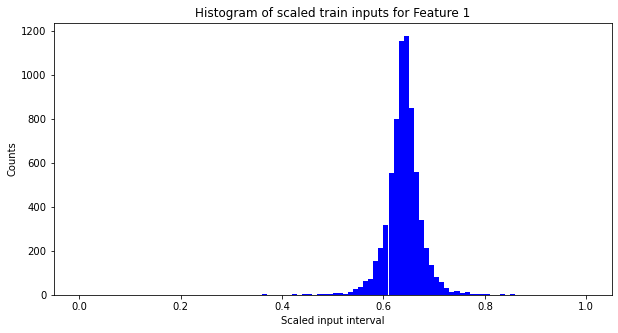

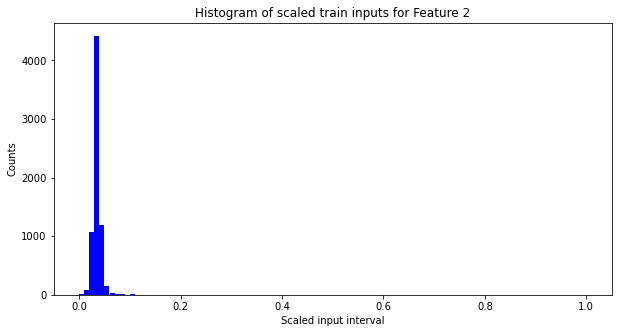

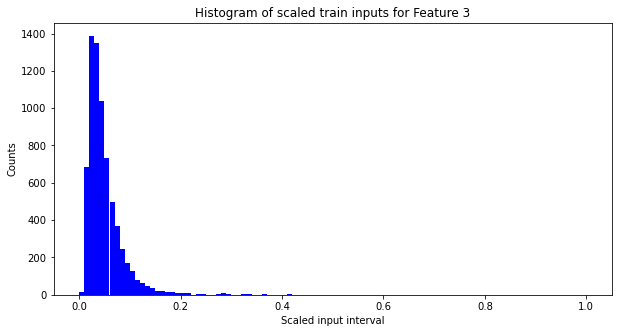

In [11]:
## Check distribution of input values after transformation for each input feature:

# Loop over input features, find number of input features as LAST dimension in train_input shape:
for i in range(train_input_scaled.shape[-1]):
    
    # Plot histogram for i-th feature
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(train_input_scaled[:,0,i], nBins, color="blue")
    axes.set_xlabel("Scaled input interval")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of scaled train inputs for Feature " + str(i+1))
    plt.show()

### Define custom loss and evaluation metrics

In [12]:
### Define custom loss function:

## Our trading model would imply going "long" if the model predicts an up movement and going "short" else.

# If prediction and target have same sign, we are actually not losing money, which should be reflected as 
# zero loss in the loss function. Whereas using the classical mse loss would assign a positive loss value if
# prediction and target point in the same direction - but deviate.
# In our trading model we only lose money if the prediction was indicating an up movement and the market declines.
# In this case we have a negative target value and we find loss = -target (to have a positive loss value).
# In addition to that we have a second scenario where we lose money: If the model indicated a down movement and
# the market gains, we have a positive target value that equals the loss. Hence loss = target (positive loss value).

# This is encountered in the following customized loss function:
def custom_loss(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target != prediction?
    eval = K.not_equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    # Multiply with targets (y_true), again need to switch dtype to fload32
    eval = eval * K.cast(K.abs(y_true), dtype='float32')
    
    return eval

# According to our trading model (described above), we can define the gain function for our strategy:
def gain(y_true, y_pred):
    
    eval = K.sign(y_pred) * y_true
    
    return eval

# And the outperformance compared to the naive buy-and-hold strategy is given by:
def outperformance(y_true, y_pred):
    
    eval = (K.sign(y_pred) - 1) * y_true
    
    return eval

### Prepare first CNN model on close (rel chg) as single input with target 1d close (rel chg)

- Try simple CNN/fc model, starting with two CNN layers, one hidden fc layer and one fc output unit.

In [44]:
# Extract first input feature close (rel chg), keep dimension to be (samples, time steps, features=1)
train_input = train_input_scaled[:,:,0:1]
val_input = val_input_scaled[:,:,0:1]
test_input = test_input_scaled[:,:,0:1]

## Chose target 1d close (rel chg), keep dimensions to be (samples, features=1):
train_target = train_target[:,0:1]
val_target = val_target[:,0:1]
test_target = test_target[:,0:1]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

## OR: Chose target 10d close (rel chg), keep dimensions to be (samples, features=1):
#train_target = train_target[:,2:3]
#val_target = val_target[:,2:3]
#test_target = test_target[:,2:3]

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

train_input shape (samples, time steps, features):  (6971, 20, 1)
val_input shape (samples, time steps, features):  (2516, 20, 1)
test_input shape (samples, time steps, features):  (587, 20, 1)

train_target shape (samples, features):  (6971, 1)
val_target shape (samples, features):  (2516, 1)
test_target shape (samples, features):  (587, 1)

train_target_bin shape (samples, features):  (6971, 1)
val_target shape_bin (samples, features):  (2516, 1)
test_target shape_bin (samples, features):  (587, 1)


In [14]:
# Set model parameters:
weight_init = tfi.glorot_uniform()
bias_init = tfi.Zeros()
batch_size = 100
n_epochs = 50
learning_rate=0.0001
input_shape = (input_length, 1) # (time steps, features)

In [15]:
# Define and compile model:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=5, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(20, activation = 'sigmoid', kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(Dense(1, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init))
   
# Use classic mse loss:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=([custom_loss, gain, outperformance]))
model.summary()
 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 10)            80        
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 20)            1020      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 20)            80        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0

2022-06-07 19:46:24.345062: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

2022-06-07 19:46:29.560823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
70/70 [==============================] - 1s 7ms/step - loss: 0.0522 - custom_loss: 0.0037 - gain: 2.5845e-04 - outperformance: -1.3140e-04 - val_loss: 0.0120 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0139 - custom_loss: 0.0038 - gain: -7.6316e-05 - outperformance: -5.1610e-04 - val_loss: 0.0062 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0093 - custom_loss: 0.0037 - gain: 2.1552e-04 - outperformance: -3.1013e-04 - val_loss: 0.0031 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00
Epoch 4/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0073 - custom_loss: 0.0038 - gain: 2.4262e-05 - outperformance: -2.8184e-04 - val_loss: 0.0011 - val_custom_loss: 0.0030 - val_gain: 4.4764e-04 - val_outperformance: -1.558

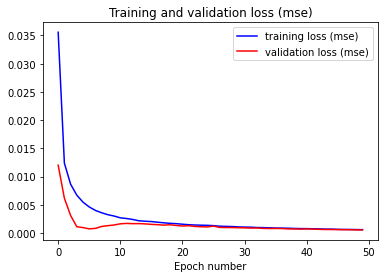

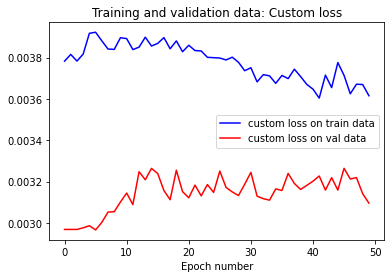

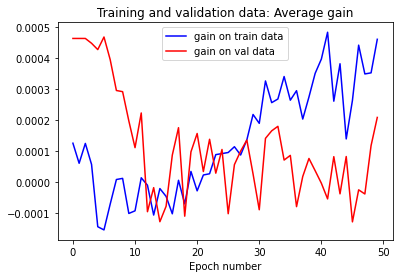

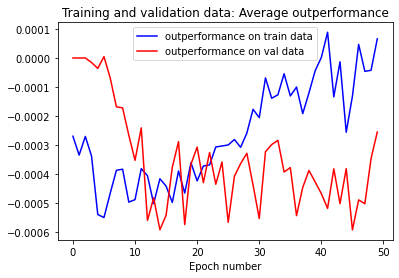

In [17]:
## Plot loss curves and optionally metrics:

## NOTE: Loss / custom loss / gain / outperformance on TRAIN data is only given as average for LAST batch.
## For VALIDATION data we already have the average over ALL samples.

# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss (mse)')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss (mse)')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss (mse)')
plt.legend()
plt.show()  

# Plot custom loss on train and val data
plt.plot(history.history['custom_loss'], color = 'blue', label = 'custom loss on train data')
plt.plot(history.history['val_custom_loss'], color = 'red', label = 'custom loss on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Custom loss')
plt.legend()
plt.show()  

# Plot gain on train and val data
plt.plot(history.history['gain'], color = 'blue', label = 'gain on train data')
plt.plot(history.history['val_gain'], color = 'red', label = 'gain on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average gain')
plt.legend()
plt.show()  

# Plot outperformance on train and val data
plt.plot(history.history['outperformance'], color = 'blue', label = 'outperformance on train data')
plt.plot(history.history['val_outperformance'], color = 'red', label = 'outperformance on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average outperformance')
plt.legend()
plt.show()  

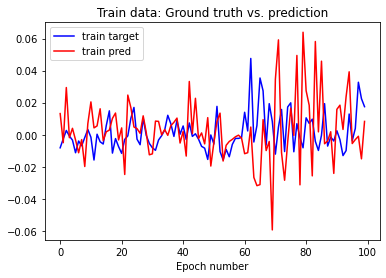

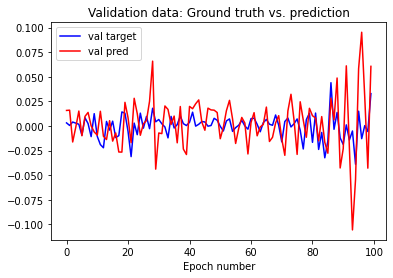

In [18]:
# Get model predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0).astype(int)
val_pred_bin = (val_pred>0).astype(int)

# Fidelity check: Train target vs. prediction
plt.plot(train_target[:100], color = 'blue', label = 'train target')
plt.plot(train_pred[:100], color = 'red', label = 'train pred')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Train data: Ground truth vs. prediction')
plt.legend()
plt.show() 

# Fidelity check: Val target vs. prediction
plt.plot(val_target[:100], color = 'blue', label = 'val target')
plt.plot(val_pred[:100], color = 'red', label = 'val pred')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Validation data: Ground truth vs. prediction')
plt.legend()
plt.show() 

In [30]:
# Get custom loss, gain and outperformance for validation samples:
val_custom_loss = custom_loss(val_target, val_pred)
val_gain = gain(val_target, val_pred)
val_outperformance = outperformance(val_target, val_pred)

In [31]:
# Check val. target vs. prediction for first 10 validation samples, vs. custom loss, gain and outperformance:
print("         target | prediction | custom loss | gain | outperformance")
np.concatenate([val_target[:10], val_pred[:10], val_custom_loss[:10], val_gain[:10], val_outperformance[:10]],
               axis=-1)

         target | predidction | custom loss | gain | outperformance


array([[ 0.00311565,  0.01578069,  0.        ,  0.00311565,  0.        ],
       [ 0.00054553,  0.01604099,  0.        ,  0.00054552,  0.        ],
       [ 0.00400127, -0.01627337,  0.00400127, -0.00400127, -0.00800253],
       [ 0.00288169, -0.00128306,  0.00288169, -0.00288169, -0.00576339],
       [ 0.00174676,  0.01515847,  0.        ,  0.00174675,  0.        ],
       [-0.00938116, -0.00996254,  0.        ,  0.00938116,  0.01876231],
       [ 0.00832585,  0.00972958,  0.        ,  0.00832585,  0.        ],
       [ 0.00242651,  0.01374349,  0.        ,  0.00242651,  0.        ],
       [-0.01082319,  0.00018813,  0.01082319, -0.01082319, -0.        ],
       [ 0.01249967, -0.00610662,  0.01249967, -0.01249967, -0.02499934]])

In [48]:
# Get binary prediction accuracy - in terms of correctly predicted up/down movements:
train_acc = np.sum(train_pred_bin == train_target_bin) / len(train_pred_bin)
val_acc = np.sum(val_pred_bin == val_target_bin) / len(val_pred_bin)

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin / len(train_target))
val_acc_naiv = np.sum(val_target_bin / len(val_target))

print("train acc (%): ", np.round(train_acc * 100,1), "%")
print("val acc (%): ", np.round(val_acc * 100,1), "%")
print("\nnaive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")

train acc (%):  50.8 %
val acc (%):  50.4 %

naive train acc (%) 53.0 %
naive val acc (%) 54.8 %


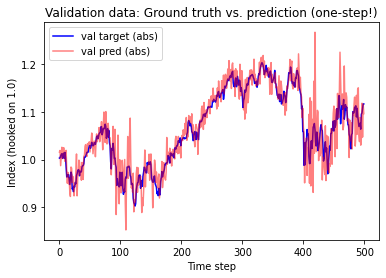

In [35]:
## Convert validation targets from rel chg back to abs values:

# Initialize storage for val_target_abs
val_target_abs = np.zeros(len(val_target))

# Loop over rel chg values in val_target, hook first value on ONE:
for i in range(len(val_target)):
    
    # First value needs special treatment, hook on ONE:
    if i == 0:
        val_target_abs[i] = 1 + val_target[i]
    else:
        val_target_abs[i] = val_target_abs[i-1] * (1 + val_target[i])
        
## Convert predictions on val data from rel chg back to abs values:

# Initialize storage for val_pred_abs
val_pred_abs = np.zeros(len(val_pred))

# Loop over rel chg values in val_pred, hook first value on ONE:
for i in range(len(val_pred)):
    
    # First value needs special treatment, hook on ONE:
    if i == 0:
        val_pred_abs[i] = 1 + val_pred[i]
    # Then hook on TRUE abs targets for next steps:
    else:
        val_pred_abs[i] = val_target_abs[i-1] * (1 + val_pred[i])

# Fidelity check: Val target vs. prediction (abs values)
plt.plot(val_target_abs[:500], color = 'blue', label = 'val target (abs)')
plt.plot(val_pred_abs[:500], color = 'red', label = 'val pred (abs)', alpha=0.5)
plt.xlabel('Time step')
plt.ylabel('Index (hooked on 1.0)')
#plt.ylim(0.6, 0.8)
plt.title('Validation data: Ground truth vs. prediction (one-step!)')
plt.legend()
plt.show() 

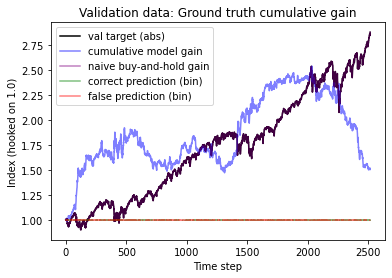

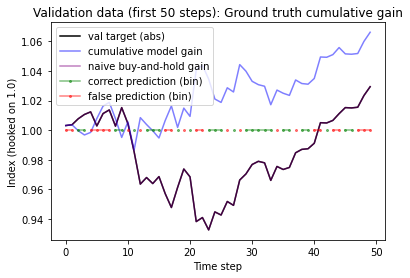

In [68]:
## Get cumulative gain from our prediction vs. gain from naive buy-and-hold strategy.

## Assume being invested only for single target period.
## Then need to decide, if we want to re-invest gain, or keep invested amount fixed. 

## If we take a fixed amount, cumulative gain is obtained by simply adding up.
## The advantage of this method is, that we can use it directly on targets longer than one day.

## Alternatively - as shown here - we can re-invest gains, when we use 1d close (rel chg) as target.
## Like this the cumulative gain from naive buy-and-hold strategy ressembles the true index.

# Initialize storage:
val_gain_cum = np.zeros(len(val_gain))
naive_gain_cum = np.zeros(len(val_target))

# Loop over time steps:
for i in range(len(val_gain)):
    
    # Hook on ZERO:
    if i == 0:
        val_gain_cum[i] = 1 * (1 + val_gain[i])
        naive_gain_cum[i] = 1 * (1 + val_target[i])
    else:
        val_gain_cum[i] = val_gain_cum[i-1] * (1 + val_gain[i])
        naive_gain_cum[i] = naive_gain_cum[i-1] * (1 + val_target[i])

## Mask correct and incorrect predictions: Start with an array of ONES.
val_pred_correct = np.ma.masked_where(val_pred_bin == val_target_bin, np.ones((len(val_pred_bin),1)))
val_pred_false = np.ma.masked_where(val_pred_bin != val_target_bin, np.ones((len(val_pred_bin),1)))

## ALL validation data:
# Performance check: Compare cumulative gain from our model prediction vs. naive buy-and-hold strategy
plt.plot(val_target_abs, color = 'black', label = 'val target (abs)')
plt.plot(val_gain_cum, color = 'blue', label = 'cumulative model gain', alpha=0.5)
plt.plot(naive_gain_cum, color = 'purple', label = 'naive buy-and-hold gain', alpha=0.5)
plt.plot(val_pred_correct, color = 'green', label = 'correct prediction (bin)', alpha=0.5)
plt.plot(val_pred_false, color = 'red', label = 'false prediction (bin)', alpha=0.5)
plt.xlabel('Time step')
plt.ylabel('Index (hooked on 1.0)')
#plt.ylim(0.6, 0.8)
plt.title('Validation data: Ground truth cumulative gain')
plt.legend()
plt.show() 

## Zoom in: First 100 validation samples
# Performance check: Compare cumulative gain from our model prediction vs. naive buy-and-hold strategy
plt.plot(val_target_abs[:50], color = 'black', label = 'val target (abs)')
plt.plot(val_gain_cum[:50], color = 'blue', label = 'cumulative model gain', alpha=0.5)
plt.plot(naive_gain_cum[:50], color = 'purple', label = 'naive buy-and-hold gain', alpha=0.5)
plt.plot(val_pred_correct[:50], color = 'green', label = 'correct prediction (bin)', alpha=0.5, marker='o', markersize=2)
plt.plot(val_pred_false[:50], color = 'red', label = 'false prediction (bin)', alpha=0.5, marker='o', markersize=2)
plt.xlabel('Time step')
plt.ylabel('Index (hooked on 1.0)')
#plt.ylim(0.6, 0.8)
plt.title('Validation data (first 50 steps): Ground truth cumulative gain')
plt.legend()
plt.show() 

### CNN/LSTM hybrid model

- Try hybrid model (used in my Master Thesis), consisting of two CNN layers and two LSTM layers on top of it.
- Still work with close (rel chg) as only input feature and 1d close (rel chg) as continuous target.
- Try classic mse loss, adjusted mse and custom loss function.
- Use custom gain and outperformance as metrics

In [25]:
# Set model parameters:
weight_init = tfi.glorot_uniform()
bias_init = tfi.Zeros()
batch_size = 100
n_epochs = 50
learning_rate=0.001
input_shape = (input_length, 1) # (time steps, features)

In [26]:
# Define and compile model:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=5, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(10))
#model.add(Dropout(0.5))
model.add(Dense(1, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init))
   
# Use classic mse loss:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=([custom_loss, gain, outperformance]))
model.summary()
 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 14, 10)            80        
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 10)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 20)            1020      
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 20)            80        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 10, 20)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 20)           

In [27]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/50
70/70 [==============================] - 3s 16ms/step - loss: 0.0020 - custom_loss: 0.0039 - gain: -8.7877e-06 - outperformance: -4.9294e-04 - val_loss: 3.9496e-04 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00
Epoch 2/50
70/70 [==============================] - 1s 8ms/step - loss: 2.1966e-04 - custom_loss: 0.0036 - gain: 3.7711e-04 - outperformance: 1.8029e-05 - val_loss: 2.9677e-04 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00
Epoch 3/50
70/70 [==============================] - 1s 8ms/step - loss: 1.9872e-04 - custom_loss: 0.0038 - gain: 1.4916e-04 - outperformance: -9.0456e-06 - val_loss: 2.2363e-04 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00
Epoch 4/50
70/70 [==============================] - 1s 8ms/step - loss: 1.6068e-04 - custom_loss: 0.0036 - gain: 5.3962e-04 - outperformance: 1.2609e-04 - val_loss: 2.3121e-04 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 -

Epoch 33/50
70/70 [==============================] - 1s 8ms/step - loss: 1.1111e-04 - custom_loss: 0.0029 - gain: 0.0018 - outperformance: 0.0014 - val_loss: 1.0073e-04 - val_custom_loss: 0.0032 - val_gain: 5.3590e-05 - val_outperformance: -4.0963e-04
Epoch 34/50
70/70 [==============================] - 1s 8ms/step - loss: 1.0717e-04 - custom_loss: 0.0029 - gain: 0.0018 - outperformance: 0.0013 - val_loss: 1.0473e-04 - val_custom_loss: 0.0034 - val_gain: -3.9889e-04 - val_outperformance: -8.6211e-04
Epoch 35/50
70/70 [==============================] - 1s 8ms/step - loss: 1.0394e-04 - custom_loss: 0.0029 - gain: 0.0019 - outperformance: 0.0016 - val_loss: 9.9901e-05 - val_custom_loss: 0.0033 - val_gain: -1.9538e-04 - val_outperformance: -6.5861e-04
Epoch 36/50
70/70 [==============================] - 1s 8ms/step - loss: 9.7677e-05 - custom_loss: 0.0028 - gain: 0.0020 - outperformance: 0.0018 - val_loss: 1.1307e-04 - val_custom_loss: 0.0032 - val_gain: -4.6397e-05 - val_outperformance: -

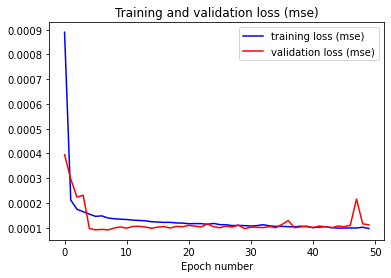

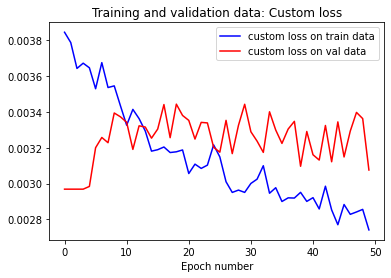

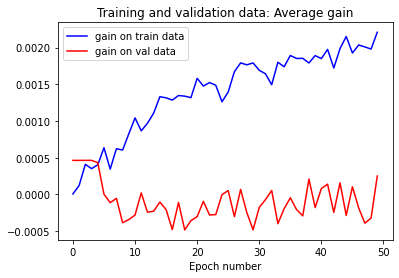

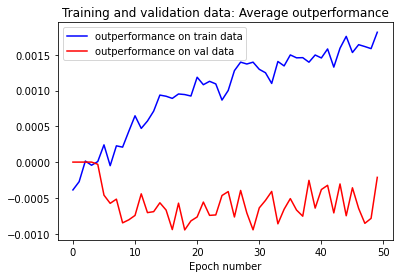

In [28]:
## Plot loss curves and optionally metrics:

## NOTE: Loss / custom loss / gain / outperformance on TRAIN data is only given as average for LAST batch.
## For VALIDATION data we already have the average over ALL samples.

# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss (mse)')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss (mse)')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss (mse)')
plt.legend()
plt.show()  

# Plot custom loss on train and val data
plt.plot(history.history['custom_loss'], color = 'blue', label = 'custom loss on train data')
plt.plot(history.history['val_custom_loss'], color = 'red', label = 'custom loss on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Custom loss')
plt.legend()
plt.show()  

# Plot gain on train and val data
plt.plot(history.history['gain'], color = 'blue', label = 'gain on train data')
plt.plot(history.history['val_gain'], color = 'red', label = 'gain on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average gain')
plt.legend()
plt.show()  

# Plot outperformance on train and val data
plt.plot(history.history['outperformance'], color = 'blue', label = 'outperformance on train data')
plt.plot(history.history['val_outperformance'], color = 'red', label = 'outperformance on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average outperformance')
plt.legend()
plt.show()  

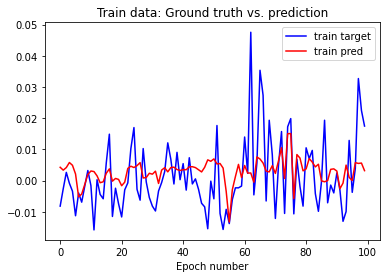

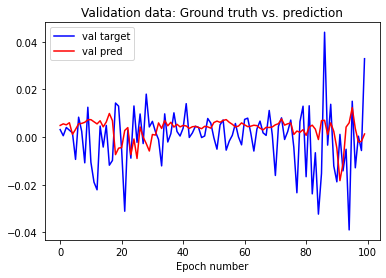

In [29]:
# Get model predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

# Fidelity check: Train target vs. prediction
plt.plot(train_target[:100], color = 'blue', label = 'train target')
plt.plot(train_pred[:100], color = 'red', label = 'train pred')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Train data: Ground truth vs. prediction')
plt.legend()
plt.show() 

# Fidelity check: Val target vs. prediction
plt.plot(val_target[:100], color = 'blue', label = 'val target')
plt.plot(val_pred[:100], color = 'red', label = 'val pred')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Validation data: Ground truth vs. prediction')
plt.legend()
plt.show() 

In [30]:
## Convert targets from rel chg back to abs values:

# Initialize storage for val_target_abs
val_target_abs = np.zeros(len(val_target))

# Loop over rel chg values in val_target, hook first value on ONE:
for i in range(len(val_target)):
    
    # First value needs special treatment, hook on ONE:
    if i == 0:
        val_target_abs[i] = 1 + val_target[i]
    else:
        val_target_abs[i] = val_target_abs[i-1] * (1 + val_target[i])

In [31]:
## Convert predictions from rel chg back to abs values:

# Initialize storage for val_pred_abs
val_pred_abs = np.zeros(len(val_pred))

# Loop over rel chg values in val_pred, hook first value on ONE:
for i in range(len(val_pred)):
    
    # First value needs special treatment, hook on ONE:
    if i == 0:
        val_pred_abs[i] = 1 + val_pred[i]
    # Then hook on TRUE abs targets for next steps:
    else:
        val_pred_abs[i] = val_target_abs[i-1] * (1 + val_pred[i])
        

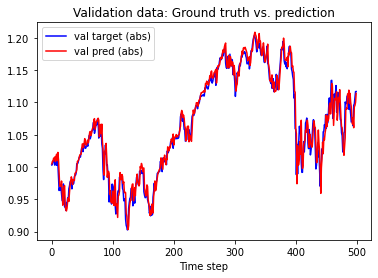

In [32]:
# Fidelity check: Val target vs. prediction (abs values)
plt.plot(val_target_abs[:500], color = 'blue', label = 'val target (abs)')
plt.plot(val_pred_abs[:500], color = 'red', label = 'val pred (abs)')
plt.xlabel('Time step')
#plt.ylim(0.6, 0.8)
plt.title('Validation data: Ground truth vs. prediction')
plt.legend()
plt.show() 

In [33]:
## Now we can already use custom_loss, gain and outperformance as evaluation metrics.
## But we want to replace the classical mse loss in training by our custom_loss.
## That requires custom_loss to be differentiable!!!

# Hence need to adjust custom loss function from above:
def custom_loss_adj(y_true, y_pred):
    
    # Get sign of predictions (y_pred)
    eval = K.sign(y_pred)
            
    # Get sign of targets (y_true)
    eval2 = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval2 = K.cast(eval2, dtype='float32')
    
    # Get boolean expression: target != prediction?
    mask = K.not_equal(eval, eval2)
    mask = K.cast(mask, dtype='float32')
  
    # Multiply mask with targets (y_true), again need to switch dtype to fload32.
    eval = mask * K.cast(K.abs(y_true), dtype='float32')
    
    # And lastly we need y_pred to be present in the returning loss, to be able to calculate
    # some gradient with respect to predicted model output in SGD learning process.
    # Use trick and multiply with sign of y_pred squared, which is just the identity:
    eval = eval * K.sign(y_pred) * K.sign(y_pred)
    
    return eval

In [164]:
# Check val. target vs. prediction for first 10 samples:
np.concatenate([val_target[:10], val_pred[:10]], axis=-1)

array([[ 0.00311565, -0.0046982 ],
       [ 0.00054553,  0.00234012],
       [ 0.00400127, -0.00284719],
       [ 0.00288169,  0.00113035],
       [ 0.00174676, -0.00465919],
       [-0.00938116, -0.00227883],
       [ 0.00832585, -0.00244274],
       [ 0.00242651,  0.00121087],
       [-0.01082319,  0.00075617],
       [ 0.01249967, -0.00108862]])

In [165]:
# Show custom loss in its original form (used as evaluation metric above):
custom_loss(val_target[:10], val_pred[:10])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.00311565],
       [0.        ],
       [0.00400127],
       [0.        ],
       [0.00174675],
       [0.        ],
       [0.00832585],
       [0.        ],
       [0.01082319],
       [0.01249967]], dtype=float32)>

In [166]:
# For comparison show adjusted custom loss, that can be used as loss function, since it is differentiable:
custom_loss_adj(val_target[:10], val_pred[:10])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.00311565],
       [0.        ],
       [0.00400127],
       [0.        ],
       [0.00174675],
       [0.        ],
       [0.00832585],
       [0.        ],
       [0.01082319],
       [0.01249967]], dtype=float32)>

In [34]:
# Define and compile model:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=5, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(10))
#model.add(Dropout(0.5))
model.add(Dense(1, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init))

# Use custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_loss_adj, metrics=(['mse', gain, outperformance]))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 14, 10)            80        
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 10)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 10, 20)            1020      
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 20)            80        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 10, 20)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 20)           

In [35]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/50
70/70 [==============================] - 3s 16ms/step - loss: 0.0039 - mse: 0.0605 - gain: -1.3621e-04 - outperformance: -3.0242e-04 - val_loss: 0.0034 - val_mse: 0.0261 - val_gain: -4.6322e-04 - val_outperformance: -9.2645e-04
Epoch 2/50
70/70 [==============================] - 1s 8ms/step - loss: 0.0037 - mse: 0.0608 - gain: 2.0519e-04 - outperformance: 2.9473e-04 - val_loss: 0.0034 - val_mse: 0.0435 - val_gain: -4.6322e-04 - val_outperformance: -9.2645e-04
Epoch 3/50
70/70 [==============================] - 1s 8ms/step - loss: 0.0039 - mse: 0.0611 - gain: -1.1285e-04 - outperformance: -5.1644e-04 - val_loss: 0.0034 - val_mse: 0.0623 - val_gain: -4.6322e-04 - val_outperformance: -9.2645e-04
Epoch 4/50
70/70 [==============================] - 1s 8ms/step - loss: 0.0039 - mse: 0.0618 - gain: -4.8825e-05 - outperformance: -2.4502e-04 - val_loss: 0.0034 - val_mse: 0.0788 - val_gain: -4.6322e-04 - val_outperformance: -9.2645e-04
Epoch 5/50
70/70 [==============================]

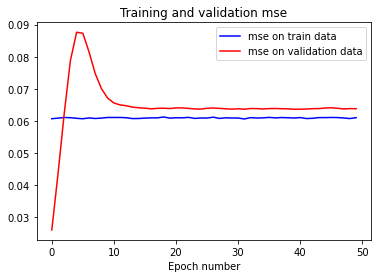

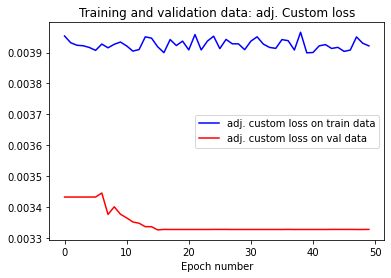

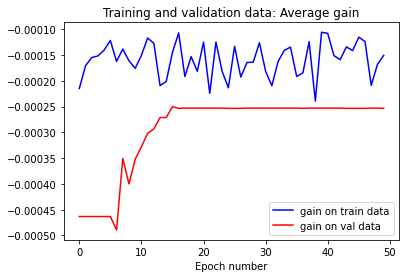

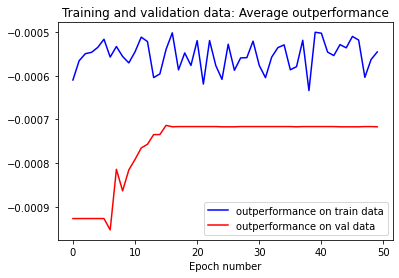

In [36]:
## Plot loss curves and optionally metrics:

## NOTE: Loss / custom loss / gain / outperformance on TRAIN data is only given as average for LAST batch.
## For VALIDATION data we have the average over ALL samples.

# Plot train and val_loss
plt.plot(history.history['mse'], color = 'blue', label = 'mse on train data')
plt.plot(history.history['val_mse'], color = 'red', label = 'mse on validation data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation mse')
plt.legend()
plt.show()  

# Plot custom loss on train and val data
plt.plot(history.history['loss'], color = 'blue', label = 'adj. custom loss on train data')
plt.plot(history.history['val_loss'], color = 'red', label = 'adj. custom loss on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: adj. Custom loss')
plt.legend()
plt.show()  

# Plot gain on train and val data
plt.plot(history.history['gain'], color = 'blue', label = 'gain on train data')
plt.plot(history.history['val_gain'], color = 'red', label = 'gain on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average gain')
plt.legend()
plt.show()  

# Plot outperformance on train and val data
plt.plot(history.history['outperformance'], color = 'blue', label = 'outperformance on train data')
plt.plot(history.history['val_outperformance'], color = 'red', label = 'outperformance on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average outperformance')
plt.legend()
plt.show()  

In [37]:
## Find the adjusted custom loss to fail.
## Try instead to adjust the classical mse loss: It shall have non-zero loss only if prediction and target deviate.
## Do this with a mask.

# Hence need to adjust classical mse loss:
def custom_mse(y_true, y_pred):
    
    # Calculate mse as squared deviation of predictions from targets:
    mse = K.square(y_true - y_pred)
    
    # Need to switch dtype to float32:
    mse = K.cast(mse, dtype='float32')
    
    # Get sign of predictions (y_pred)
    eval1 = K.sign(y_pred)
            
    # Get sign of targets (y_true)
    eval2 = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval2 = K.cast(eval2, dtype='float32')
    
    # Get boolean expression: target != prediction?
    mask = K.not_equal(eval1, eval2)
    mask = K.cast(mask, dtype='float32')
    
    # Get adjusted mse:
    eval = mask * mse
    
    return eval

In [178]:
# Check val. target vs. prediction for first 10 samples:
np.concatenate([val_target[:10], val_pred[:10]], axis=-1)

array([[ 0.00311565, -0.0046982 ],
       [ 0.00054553,  0.00234012],
       [ 0.00400127, -0.00284719],
       [ 0.00288169,  0.00113035],
       [ 0.00174676, -0.00465919],
       [-0.00938116, -0.00227883],
       [ 0.00832585, -0.00244274],
       [ 0.00242651,  0.00121087],
       [-0.01082319,  0.00075617],
       [ 0.01249967, -0.00108862]])

In [179]:
# Show custom mse:
custom_mse(val_target[:10], val_pred[:10])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[6.1056249e-05],
       [0.0000000e+00],
       [4.6901376e-05],
       [0.0000000e+00],
       [4.1036172e-05],
       [0.0000000e+00],
       [1.1596266e-04],
       [0.0000000e+00],
       [1.3408145e-04],
       [1.8464163e-04]], dtype=float32)>

In [38]:
# Define and compile model:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=5, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(10))
#model.add(Dropout(0.5))
model.add(Dense(1, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init))

# Use classical mse as loss and track custom mse as metric:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=([custom_mse, gain, outperformance]))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 14, 10)            80        
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 10)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 20)            1020      
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 20)            80        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 10, 20)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 20)           

In [39]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/50
70/70 [==============================] - 3s 14ms/step - loss: 0.0010 - custom_mse: 6.8768e-04 - gain: 6.1540e-05 - outperformance: -5.7788e-04 - val_loss: 8.8639e-05 - val_custom_mse: 5.6333e-05 - val_gain: 4.8239e-04 - val_outperformance: 1.9167e-05
Epoch 2/50
70/70 [==============================] - 1s 8ms/step - loss: 2.2237e-04 - custom_mse: 1.7884e-04 - gain: 2.7631e-04 - outperformance: -3.5471e-05 - val_loss: 9.5210e-05 - val_custom_mse: 6.1529e-05 - val_gain: -4.4836e-04 - val_outperformance: -9.1159e-04
Epoch 3/50
70/70 [==============================] - 1s 8ms/step - loss: 1.6304e-04 - custom_mse: 1.2631e-04 - gain: -1.6049e-05 - outperformance: -4.1705e-04 - val_loss: 1.1683e-04 - val_custom_mse: 8.8398e-05 - val_gain: -4.2642e-04 - val_outperformance: -8.8965e-04
Epoch 4/50
70/70 [==============================] - 1s 8ms/step - loss: 1.4675e-04 - custom_mse: 1.0124e-04 - gain: 5.2008e-04 - outperformance: 3.0778e-05 - val_loss: 1.1266e-04 - val_custom_mse: 8.2278

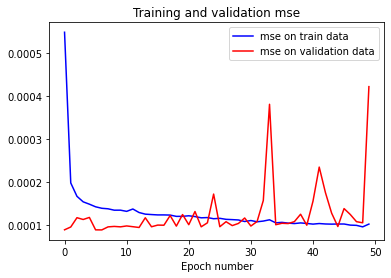

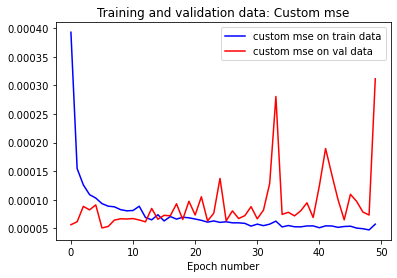

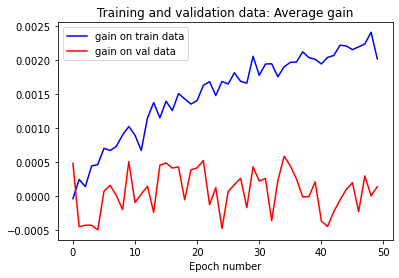

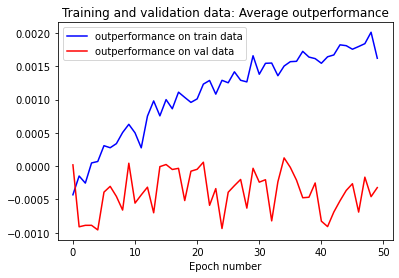

In [40]:
## Plot loss curves and optionally metrics:

## NOTE: Loss / custom loss / gain / outperformance on TRAIN data is only given as average for LAST batch.
## For VALIDATION data we have the average over ALL samples.

# Plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'mse on train data')
plt.plot(history.history['val_loss'], color = 'red', label = 'mse on validation data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation mse')
plt.legend()
plt.show()  

# Plot custom loss on train and val data
plt.plot(history.history['custom_mse'], color = 'blue', label = 'custom mse on train data')
plt.plot(history.history['val_custom_mse'], color = 'red', label = 'custom mse on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Custom mse')
plt.legend()
plt.show()  

# Plot gain on train and val data
plt.plot(history.history['gain'], color = 'blue', label = 'gain on train data')
plt.plot(history.history['val_gain'], color = 'red', label = 'gain on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average gain')
plt.legend()
plt.show()  

# Plot outperformance on train and val data
plt.plot(history.history['outperformance'], color = 'blue', label = 'outperformance on train data')
plt.plot(history.history['val_outperformance'], color = 'red', label = 'outperformance on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average outperformance')
plt.legend()
plt.show()  

In [41]:
# Define and compile model:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=5, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(10))
#model.add(Dropout(0.5))
model.add(Dense(1, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init))

# Now use custom mse as loss and track classical mse as metric:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_mse, metrics=(['mse', gain, outperformance]))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 14, 10)            80        
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 10)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 10, 20)            1020      
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 20)            80        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 10, 20)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 20)           

In [42]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/50
70/70 [==============================] - 3s 14ms/step - loss: 0.0012 - mse: 0.0018 - gain: -7.8739e-05 - outperformance: -4.9256e-04 - val_loss: 2.6655e-04 - val_mse: 3.2199e-04 - val_gain: -4.6322e-04 - val_outperformance: -9.2645e-04
Epoch 2/50
70/70 [==============================] - 1s 8ms/step - loss: 1.6039e-04 - mse: 2.0678e-04 - gain: -1.4545e-04 - outperformance: -4.0667e-04 - val_loss: 1.7248e-04 - val_mse: 2.0499e-04 - val_gain: -4.6322e-04 - val_outperformance: -9.2645e-04
Epoch 3/50
70/70 [==============================] - 1s 8ms/step - loss: 1.2074e-04 - mse: 1.7078e-04 - gain: 2.6391e-04 - outperformance: -1.2825e-04 - val_loss: 6.4118e-05 - val_mse: 9.6750e-05 - val_gain: -4.0152e-04 - val_outperformance: -8.6474e-04
Epoch 4/50
70/70 [==============================] - 1s 8ms/step - loss: 1.1023e-04 - mse: 1.5623e-04 - gain: 3.1452e-04 - outperformance: -2.9039e-04 - val_loss: 8.0448e-05 - val_mse: 1.0364e-04 - val_gain: 4.6322e-04 - val_outperformance: 0.0000

Epoch 34/50
70/70 [==============================] - 1s 8ms/step - loss: 5.2968e-05 - mse: 1.2733e-04 - gain: 0.0010 - outperformance: 3.9216e-04 - val_loss: 4.6201e-05 - val_mse: 8.6851e-05 - val_gain: 3.4150e-06 - val_outperformance: -4.5981e-04
Epoch 35/50
70/70 [==============================] - 1s 8ms/step - loss: 4.6146e-05 - mse: 1.2430e-04 - gain: 0.0014 - outperformance: 0.0010 - val_loss: 5.2208e-05 - val_mse: 8.7016e-05 - val_gain: 4.4165e-04 - val_outperformance: -2.1569e-05
Epoch 36/50
70/70 [==============================] - 1s 8ms/step - loss: 5.7149e-05 - mse: 1.2956e-04 - gain: 0.0012 - outperformance: 7.3413e-04 - val_loss: 4.7651e-05 - val_mse: 8.6217e-05 - val_gain: 3.4788e-04 - val_outperformance: -1.1534e-04
Epoch 37/50
70/70 [==============================] - 1s 8ms/step - loss: 5.5254e-05 - mse: 1.2240e-04 - gain: 0.0010 - outperformance: 5.5677e-04 - val_loss: 4.8160e-05 - val_mse: 8.6418e-05 - val_gain: 4.2308e-04 - val_outperformance: -4.0145e-05
Epoch 38/50


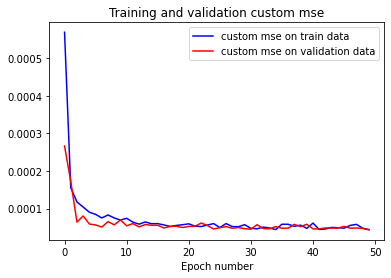

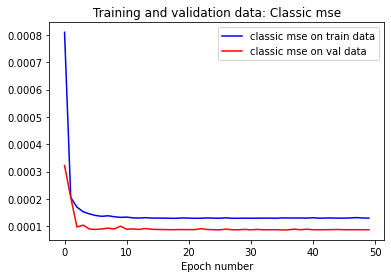

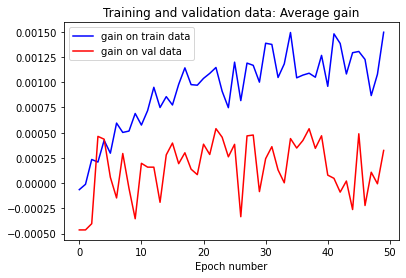

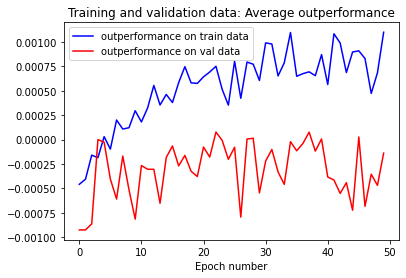

In [43]:
## Plot loss curves and optionally metrics:

## NOTE: Loss / custom loss / gain / outperformance on TRAIN data is only given as average for LAST batch.
## For VALIDATION data we have the average over ALL samples.

# Plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'custom mse on train data')
plt.plot(history.history['val_loss'], color = 'red', label = 'custom mse on validation data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation custom mse')
plt.legend()
plt.show()  

# Plot custom loss on train and val data
plt.plot(history.history['mse'], color = 'blue', label = 'classic mse on train data')
plt.plot(history.history['val_mse'], color = 'red', label = 'classic mse on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Classic mse')
plt.legend()
plt.show()  

# Plot gain on train and val data
plt.plot(history.history['gain'], color = 'blue', label = 'gain on train data')
plt.plot(history.history['val_gain'], color = 'red', label = 'gain on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average gain')
plt.legend()
plt.show()  

# Plot outperformance on train and val data
plt.plot(history.history['outperformance'], color = 'blue', label = 'outperformance on train data')
plt.plot(history.history['val_outperformance'], color = 'red', label = 'outperformance on val data')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation data: Average outperformance')
plt.legend()
plt.show()  

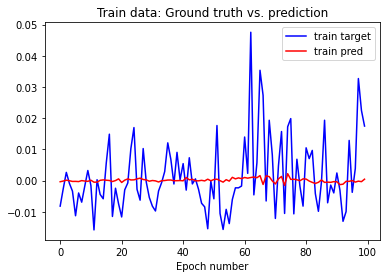

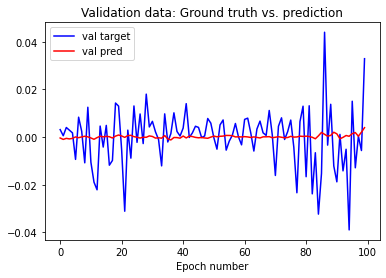

In [45]:
# Get model predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

# Fidelity check: Train target vs. prediction
plt.plot(train_target[:100], color = 'blue', label = 'train target')
plt.plot(train_pred[:100], color = 'red', label = 'train pred')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Train data: Ground truth vs. prediction')
plt.legend()
plt.show() 

# Fidelity check: Val target vs. prediction
plt.plot(val_target[:100], color = 'blue', label = 'val target')
plt.plot(val_pred[:100], color = 'red', label = 'val pred')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Validation data: Ground truth vs. prediction')
plt.legend()
plt.show() 